In [1]:
import chess
import numpy as np
import pandas as pd
import random

from pre_defined_functions.py import evaluate_piece_activity,evaluate_pawn_structure,count_defenses,evaluate_king_safety

In [2]:
def is_valid_move(board, move_uci):
    #chess.Board, (chess.Move or str UCI notation) -> Bool
    if type(move_uci) == str:
        try:
            move = chess.Move.from_uci(move_uci)
            return move in board.legal_moves
        except:
            return False
    else:
        try:
            return move_uci in board.legal_moves
        except:
            return False

def get_all_possible_moves(board):
    #chess.Board -> list with all possible moves in the position
    #the color to move is stated by the chess.Board attribute
    
    possible_moves = []
    for legal_move in board.legal_moves:
        possible_moves.append(legal_move)

    return possible_moves

def fen_to_matrix(fen):
    #str FEN notation -> (8x8 list representing the board, list with castling rights, list en_passant possibility, color to move)
    
    board = chess.Board(fen)
    piece_map = board.piece_map()
    
    matrix = [[' '] * 8 for _ in range(8)]
    
    for square, piece in piece_map.items():
        rank, file = chess.square_rank(square), chess.square_file(square)
        matrix[7 - rank][file] = piece.symbol()
            
    castling_flags = [
        1 if sym in board.fen().split(' ')[2]
        else 0 
        for sym in 'KQkq'
    ]

    en_passant_square = board.ep_square
    en_passant_info = [
        0 if en_passant_square == None else
        0 if 7 - en_passant_square // 8 != row else 
        1 
        for row in range(8)
    ]

    color_to_move = 1 if board.turn else 0

    return matrix, castling_flags, en_passant_info, color_to_move

def apply_move(board, move_uci):
    #chess.Board, movimento valido (str UCI notation or chess.move) -> novo chess.Board com o movimento aplicado
    new_board = board.copy()
    if type(move_uci) == str:
        new_board.push_uci(move_uci)
    else:
        new_board.push(move_uci)
    return new_board

def numerical_board(matrix):
    #8x8 list categorica -> 8x8 list numerica
    piece_to_int = {' ': 0, 'p': -1, 'r': -5, 'n': -3, 'b': -4, 'q': -9, 'k': -10,
                'P': 1, 'R': 5, 'N': 3, 'B': 4, 'Q': 9, 'K': 10}
    return [[piece_to_int[piece] for piece in row] for row in matrix]

def get_dummy_eval(board):
    #(8x8 numerical list or chess.Board) -> int contagem material
    if type(board) == chess.Board: 
        fen = board.fen()
        board = numerical_board(fen_to_matrix(fen)[0])
        
    evaluation = 0
    for row in board:
        for piece in row:
            if piece == 4 or piece == -4:
                evaluation += piece - piece/4
            else:
                evaluation += piece
    return evaluation

def minimax(board, depth, maximizing_player):
    #(chess.Board, int profundidade, bool jogador da vez) -> evaluation
    # dada uma profundidade, verifica com recurssão pelo modelo qual sequencia de lances mais plausivel a ser feita pelos dois jogadores
    if board.is_game_over or depth == 0:
        return get_model_eval(board)
    
    possible_moves = get_all_possible_moves(board)

    if maximizing_player:
        max_eval = float('-inf')
        for move in possible_moves:
            new_board = apply_move(board, move)
            eval = minimax(new_board, depth - 1, False)
            max_eval = max(max_eval, eval)
        return max_eval
    else:
        min_eval = float('inf')
        for move in possible_moves:
            new_board = apply_move(board, move)
            eval = minimax(new_board, depth - 1, True)
            min_eval = min(min_eval, eval)
        return min_eval
    
def get_best_move(board,depth):
    #(chess.Board, int profundidade) -> chess.move
    # verifica para cada lance, utilizando a minimax(), qual a linha mais plausivel e retorna o lance com a linha melhor avaliada pelo modelo
    maximizing_player = board.turn
    best_move = None
    best_score = float('-inf') if maximizing_player else float('inf')

    for move in get_all_possible_moves(board):
        new_board = apply_move(board, move)
        score = minimax(new_board, depth=depth, maximizing_player=not maximizing_player)

        if (maximizing_player and score > best_score) or (not maximizing_player and score < best_score):
            best_score = score
            best_move = move

    return best_move

import time

def get_best_move_aspiration(board, max_time_seconds=5):
    #(chess.Board, float tempo maximo a ser tomado para executar) -> chess.move
    #retorna o lance, se for lance teorico ou unico lance possivel. Caso nao caia em nenhum dos casos, aumenta gradativamente a profundidade a ser passada para a get_best_move() até que o tempo estipulado seja alcancado.
    
    start_time = time.time()
    depth = 3
    best_move = None
    
    possible_moves = get_all_possible_moves(board)
    if len(possible_moves) == 1:
        return possible_moves[0]
    for move in get_all_possible_moves(board):
        new_board = apply_move(board, move)
        if new_board.fen() in good_openings:
            return move

    while time.time() - start_time < max_time_seconds:
        new_best_move = get_best_move(board, depth)
        if new_best_move:
            best_move = new_best_move
        else:
            break  # Exit if no move found at the current depth

        # Perform an aspiration search by trying a deeper search with the last best move
        new_best_move_deeper = get_best_move(board, depth + 1)
        if new_best_move_deeper:
            best_move = new_best_move_deeper

        depth += 2  # Increase depth unevenly, you can adjust this based on your preference

    return best_move

In [31]:
file_path = '/Users/pedro/Downloads/lichess_db_eval.json'

i = 0
df = pd.read_json(file_path, lines = True, chunksize=10000) #escolher chunksize para decidir quantas linhas ler na base (max ~9M)

database = pd.DataFrame({'fen':[],'evals':[]})
i = 0
for chunk in df:
    if i > 0:
        break
    database = pd.concat([chunk, database])
    i += 1



In [32]:
database

,fen,evals
0,rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w ...,"[{'pvs': [{'cp': 18, 'line': 'e2e4 e7e5 g1f3 b..."
1,rnbqk1nr/pp2p1bp/3p2p1/2pP1p2/2P5/2N2N2/PP2PPP...,"[{'pvs': [{'cp': 64, 'line': 'g2g3 g8f6 f1g2 e..."
2,2Rb2k1/3q1rpp/p3Q3/2N1p3/4P3/3Pp3/1P4PP/1K6 b - -,"[{'pvs': [{'cp': 0, 'line': 'd7c8 e6c8 e3e2 c8..."
3,rnbqkb1r/ppp1pppp/5n2/3p4/3P1B2/8/PPP1PPPP/RN1...,"[{'pvs': [{'cp': 6, 'line': 'e2e3 c7c5 g1f3 b8..."
4,2b1k3/pr5R/1p2pr2/5p2/2pP4/2P5/PP3PB1/R5K1 w - -,"[{'pvs': [{'cp': 994, 'line': 'g2b7 f6g6 g1f1 ..."
...,...,...
9995,3Q4/4rk2/8/3K4/8/8/8/8 b - -,"[{'pvs': [{'cp': 793, 'line': 'e7e2 d8c7 e2e7 ..."
9996,r1bqk2r/pp1p1ppp/2n2n2/8/1b1NP3/2N5/PP3PPP/R1B...,"[{'pvs': [{'cp': 15, 'line': 'd4c6 b7c6 f1d3 d..."
9997,8/K7/1P1k4/8/8/8/8/8 b - -,"[{'pvs': [{'mate': 11, 'line': 'd6c5 b6b7 c5d4..."
9998,3Q4/5k2/8/3K4/8/8/4r3/8 w - -,"[{'pvs': [{'mate': 21, 'line': 'd8c7 e2e7 c7f4..."


In [33]:
#apply's demorando bastante pra rodar

database['board'] = [chess.Board(fen) for fen in database.fen]
database['material'] = database['board'].apply(get_dummy_eval)
database['pawn_structure'] = database['board'].apply(evaluate_pawn_structure)
database['king_safety'] = database['board'].apply(evaluate_king_safety)
database['piece_activity'] = database['board'].apply(evaluate_piece_activity)
database['turn'] = [1 if board.turn else -1 for board in database['board']]

database['eval_mate'] = [0 if 'cp'in evals[0]['pvs'][0] else
                         1 if 'mate'in evals[0]['pvs'][0] else
                         'erro'for evals in database['evals']]

database['eval'] = [evals[0]['pvs'][0]['cp'] if eval_type == 0 else
                    10000 - evals[0]['pvs'][0]['mate']
                    for evals,eval_type in zip(database['evals'],database['eval_mate'])]


In [34]:
database

,fen,evals,board,material,pawn_structure,king_safety,piece_activity,turn,eval_mate,eval
0,rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w ...,"[{'pvs': [{'cp': 18, 'line': 'e2e4 e7e5 g1f3 b...",r n b q k b n r\np p p p p p p p\n. . . . . . ...,0,1.0,2.4,16.40,1,0,18
1,rnbqk1nr/pp2p1bp/3p2p1/2pP1p2/2P5/2N2N2/PP2PPP...,"[{'pvs': [{'cp': 64, 'line': 'g2g3 g8f6 f1g2 e...",r n b q k . n r\np p . . p . b p\n. . . p . . ...,0,0.8,1.6,29.10,1,0,64
2,2Rb2k1/3q1rpp/p3Q3/2N1p3/4P3/3Pp3/1P4PP/1K6 b - -,"[{'pvs': [{'cp': 0, 'line': 'd7c8 e6c8 e3e2 c8...",. . R b . . k .\n. . . q . r p p\np . . . Q . ...,-1,-0.1,-0.9,-10.60,-1,0,0
3,rnbqkb1r/ppp1pppp/5n2/3p4/3P1B2/8/PPP1PPPP/RN1...,"[{'pvs': [{'cp': 6, 'line': 'e2e3 c7c5 g1f3 b8...",r n b q k b . r\np p p . p p p p\n. . . . . n ...,0,0.4,1.8,25.40,1,0,6
4,2b1k3/pr5R/1p2pr2/5p2/2pP4/2P5/PP3PB1/R5K1 w - -,"[{'pvs': [{'cp': 994, 'line': 'g2b7 f6g6 g1f1 ...",. . b . k . . .\np r . . . . . R\n. p . . p r ...,0,0.3,0.9,16.10,1,0,994
...,...,...,...,...,...,...,...,...,...,...
9995,3Q4/4rk2/8/3K4/8/8/8/8 b - -,"[{'pvs': [{'cp': 793, 'line': 'e7e2 d8c7 e2e7 ...",. . . Q . . . .\n. . . . r k . .\n. . . . . . ...,4,-0.0,0.5,-1.70,-1,0,793
9996,r1bqk2r/pp1p1ppp/2n2n2/8/1b1NP3/2N5/PP3PPP/R1B...,"[{'pvs': [{'cp': 15, 'line': 'd4c6 b7c6 f1d3 d...",r . b q k . . r\np p . p . p p p\n. . n . . n ...,0,0.3,1.0,29.60,1,0,15
9997,8/K7/1P1k4/8/8/8/8/8 b - -,"[{'pvs': [{'mate': 11, 'line': 'd6c5 b6b7 c5d4...",. . . . . . . .\nK . . . . . . .\n. P . k . . ...,1,0.2,-0.0,-0.55,-1,1,9989
9998,3Q4/5k2/8/3K4/8/8/4r3/8 w - -,"[{'pvs': [{'mate': 21, 'line': 'd8c7 e2e7 c7f4...",. . . Q . . . .\n. . . . . k . .\n. . . . . . ...,4,0.0,-0.4,2.50,1,1,9979


In [35]:
X_columns = ['material','pawn_structure','king_safety','piece_activity','turn']
X = database[X_columns]
y = database['eval']

In [ ]:
'''
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

model = RandomForestRegressor()

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train_scaled, y_train)

best_model = grid_search.best_estimator_

model.fit(X_train_scaled, y_train)

y_pred = best_model.predict(X_test_scaled)

mse = mean_squared_error(y_test, y_pred)

print(f'Best Model - Mean Squared Error: {mse}')
print('Best Hyperparameters:', grid_search.best_params_'
'''

In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = RandomForestRegressor() #parametros ajustados na celula comentada anterior
model.fit(X_train_scaled, y_train)

mse = mean_squared_error(y_test, y_pred)
print(f'Model - Mean Squared Error: {mse}')

In [143]:
X_train.columns


Index(['material', 'pawn_structure', 'king_safety', 'piece_activity', 'turn'], dtype='object')

In [144]:
def get_model_eval(board):
    material = get_dummy_eval(board)
    pawn_structure = evaluate_pawn_structure(board)
    king_safety = evaluate_king_safety(board)
    piece_activity = evaluate_piece_activity(board)
    turn = 1 if board.turn else -1
    features = np.array([material,pawn_structure,king_safety,piece_activity,turn])
    features_2d = np.array(features).reshape(1, -1)
    
    return model.predict(features_2d)
    
    
    

In [145]:
openings_inter = pd.read_json('eco_interpolated.json')
openings_inter = openings_inter.T
openings_inter.reset_index(inplace=True)
openings_inter['fen'] = openings_inter['index']

openings_base = pd.read_json('eco.json')
openings2 = pd.concat([openings_base, openings_inter])

openings2.reset_index(inplace=True)

In [146]:
openings2['opening'] = [name.split(':')[0].split(',')[0] for name in openings2['name']]
worst_50_openings = [
    "Ware Defense",
    "Carr Defense",
    "Montevideo Defense",
    "Grob Opening",
    "Grob Gambit",
    "Hodgson Attack",
    "Barnes Opening",
    "Borg Defense",
    "Mexican Defense",
    "Goldsmith Defense",
    "Owen Defence",
    "Barnes Defense",
    "Irish Gambit",
    "Global Opening",
    "Amsterdam Attack",
    "Amazon Attack",
    "Crab Opening",
    "Creepy Crawly Formation",
    "Danish Gambit",
    "Elephant Gambit",
    "Englund Gambit",
    "Englund Gambit Accepted",
    "Englund Gambit Complex",
    "Englund Gambit Declined",
    "Fried Fox Defense",
    "Lemming Defense",
    "Lion Defense",
    "Mieses",
    "Pterodactyl Defense",
    "Paleface Attack",
    "Sodium Attack",
    "Amar Gambit",
    "Amar Opening",
    "Anderssen's Opening",
    "Australian Defense",
    "Basman's Creepy-Crawly System (as Black)",
    "Benko Opening",
    "Blackburne Shilling Gambit",
    "Blumenfeld Countergambit",
    "Bogo-Indian Defense",
    "Bongcloud Attack",
    "Budapest",
    "Canard Opening",
    "Catalan Opening",
    "Center Game",
    "Chigorin Defense"
]

good_openings = openings2[~(openings2['opening'].isin(worst_50_openings))]['fen'].tolist()

In [147]:
def play_engine(color,depth):
    if color == None:
        rand_int = np.random.randint(0,2)
        if rand_int == 1:
            color = 'white'
        else:
            color = 'black'
    print(f'Playing {color}')
            
    initial_fen = "rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w KQkq - 0 1"
    #initial_fen = '8/8/8/2pk1P2/8/8/4K3/8 w - - 0 1'
    chessboard = chess.Board(initial_fen)
    
    while not chessboard.is_game_over():
        
        display(chessboard)
    
        if color == 'white':
            if chessboard.turn:
                move = input('Move (UCI notation): ')
            else:
                print('Loading Engine move...')
                move = get_best_move_aspiration(chessboard,40)
            
        else:
            if chessboard.turn:
                print('Loading Engine move...')
                move = get_best_move_aspiration(chessboard,40)
            else:
                move = input('Move (UCI notation): ')
                
        print(move)
        if is_valid_move(chessboard,move):
            chessboard = apply_move(chessboard,move)
        else:
            print('Not a valid move')
    
    print('Game Over')
    
    return

Playing white


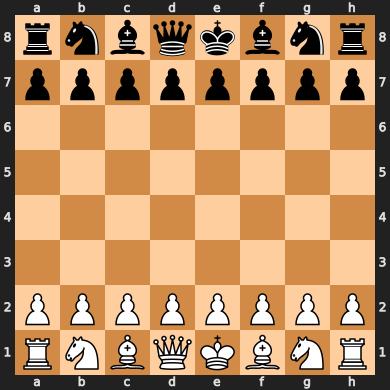

Move (UCI notation): d2d4
d2d4


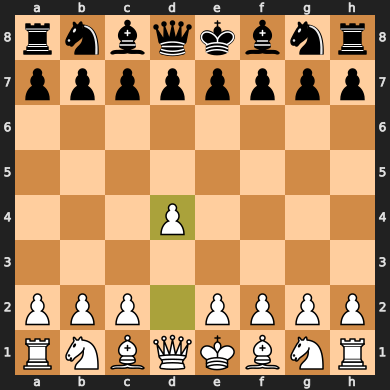

Loading Engine move...
g8f6


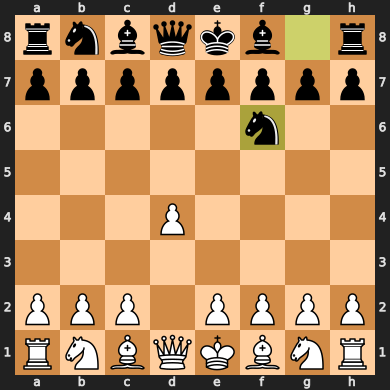

Move (UCI notation): c2c4
c2c4


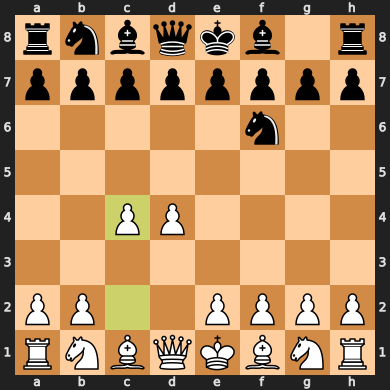

Loading Engine move...
g7g6


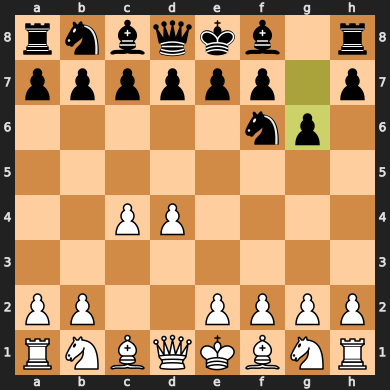

Move (UCI notation): b1c3
b1c3


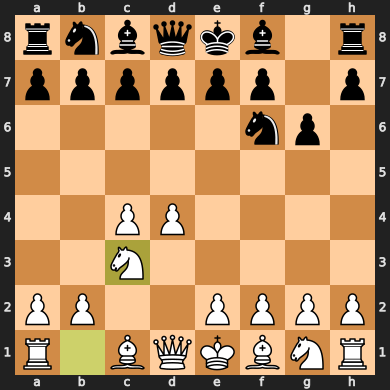

Loading Engine move...
f8g7


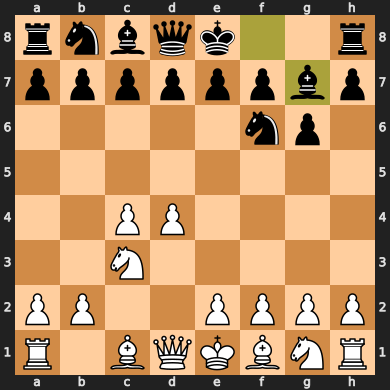

Move (UCI notation): e2e4
e2e4


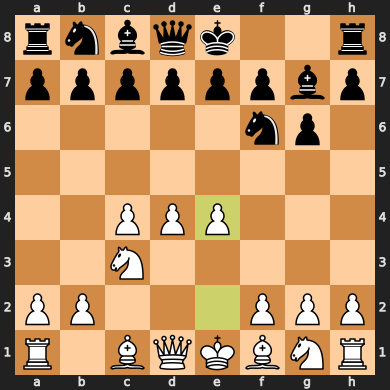

Loading Engine move...
e8g8


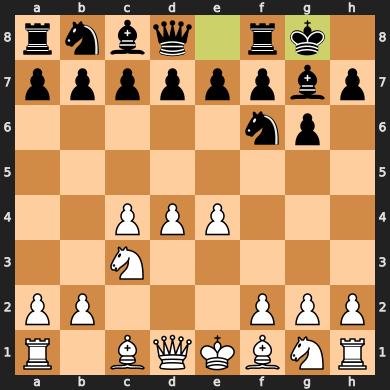

Move (UCI notation): e4e5
e4e5


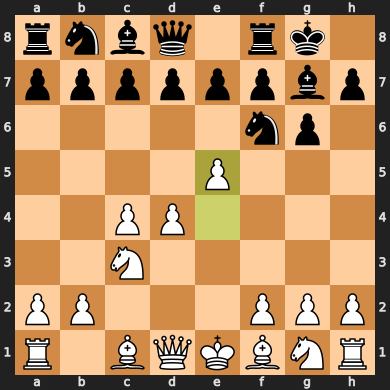

Loading Engine move...
g8h8


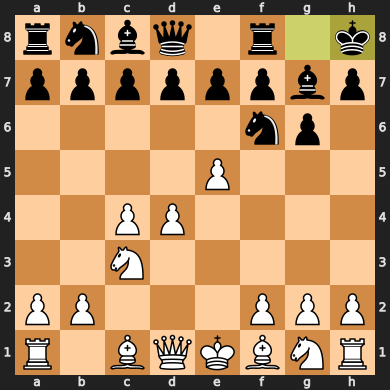

Move (UCI notation): e5f6
e5f6


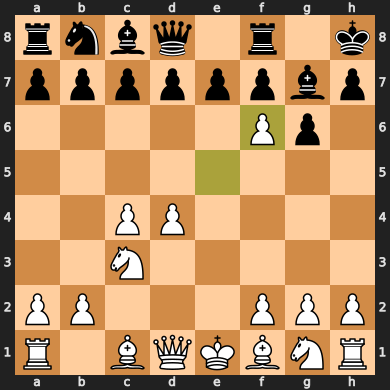

Loading Engine move...
e7f6


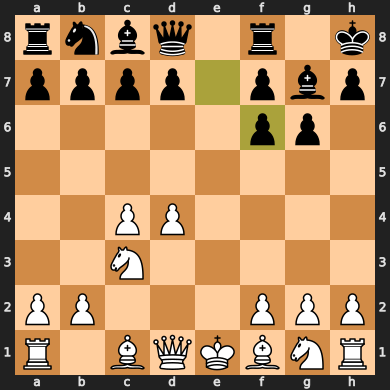

KeyboardInterrupt: Interrupted by user

In [148]:
play_engine('white',600)